In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [30]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [34]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [35]:
#get column information (station)
first_row_station = session.query(station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11ae2e190>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [36]:
#get column info (measurement)
first_row_measure = session.query(measurement).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11ae45690>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

# 1 year before last date is query_date 
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
twelvemonth = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).statement
twelvemonth

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(twelvemonth, conn)
df=df.rename(columns={'date':'Date',
                  'prcp':'Precipitation'})
df=df.set_index('Date')

# Sort the dataframe by date
date_df=df.sort_values('Date')
date_df=date_df.dropna()
date_df

('2017-08-23',)
Query Date:  2016-08-23


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


Text(0, 0.5, 'Precipitation (inches)')

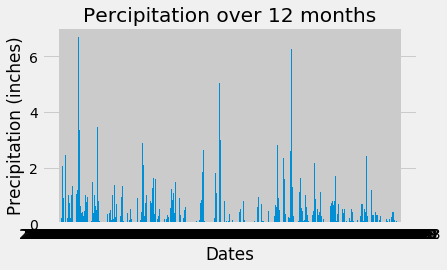

In [78]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = date_df.index
y_axis =date_df.Precipitation

#format months
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()

plt.bar(x_axis,y_axis)
plt.title('Percipitation over 12 months')
plt.xlabel('Dates')
plt.ylabel('Precipitation (inches)')

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


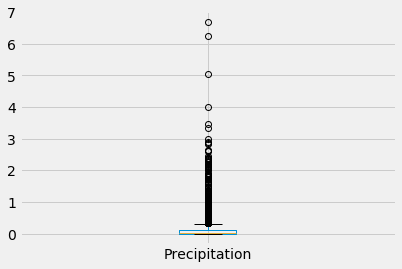

In [81]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.boxplot('Precipitation')
date_df.describe()

In [110]:
# Design a query to show how many stations are available in this dataset?

station_count=session.query(station.id).count()
print(f'There are {station_count} weather stations.')

There are 9 weather stations


In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(measurement.station, station.name, func.count(measurement.id)).\
    filter(measurement.station == station.station).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_station
print(f'The most active station (count = {active_station[0][2]}) id is {active_station[0][0]}.')
print(f'The least active station (count = {active_station[-1][2]}) id is {active_station[-1][0]}.')


The most active station (count = 2772) id is USC00519281.
The least active station (count = 511) id is USC00518838.


In [163]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

from statistics import mean 

most_active_station_temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).count()

most_temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).all()

# most_active_station_temps is a list of tuples. unpack into list of integers
temperatures = [temp[0] for temp in most_temps]                

low_temp=min(temperatures)
high_temp=max(temperatures)
avg_temp=mean(temperatures)

print(f'{active_station[0][0]} has a total of {most_active_station_temps} temperature observations')
print(f' The lowest temp recorded is {low_temp}, the highest temp recorded is {high_temp}, and the average temp is {round(avg_temp,2)} from the most active station ({active_station[0][0]}).')


2772
USC00519281 has a total of 2772 temperature observations
 The lowest temp recorded is 54.0, the highest temp recorded is 85.0, and the average temp is 71.66 from the most active station (USC00519281).


USC00519281 has a total of 352 temperature observations in the past year.


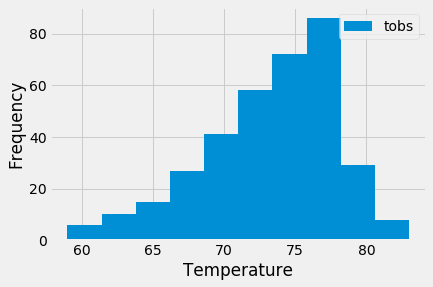

In [176]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_count = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).filter(measurement.date>='2016-08-23').count()
print(f'{active_station[0][0]} has a total of {year_count} temperature observations in the past year.')

year_temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).filter(measurement.date>='2016-08-23').all()
                                                                                
yeartemperatures = [temp[0] for temp in year_temps] 
plt.hist(yeartemperatures, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc=1)




## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
